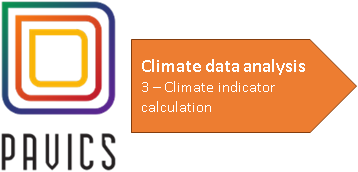
<a id='top'></a>

This third tutorial will demonstate PAVICS tools for calculating climate indicators, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS incorporates the [xclim](https://xclim.readthedocs.io/en/stable/) library which essentially has two layers for the calculation of indicators. The first `xclim.indices` is a core layer and containing the various algorithms and calculation logic, as well as any potential unit conversions.  A second layer consists of `xclim.core.indicator.Indicator` instances that essentially perform the same computations found in `xclim.indices`, but also run a number of health checks on input data and assign attributes to the output arrays. Indicators are split into realms (`atmos`, `land`, `seaIce`), according to the variables they operate on. 

This tutorial uses [xclim's](https://xclim.readthedocs.io/en/stable/) `atmos` module outlining steps for:

* [Climate indicator calculation](#climcalc)
* [Missing data options](#missing)
* [French language metadata fields](#french)

Advanced topics:

* [Simple multiprocessing of an ensemble](#multiproc)

We re-use part of the data-access and subset tutorials to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.
___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 60, time: 55115)
Coordinates:
  * lat      (lat) float32 48.96 48.87 48.79 48.71 ... 48.29 48.21 48.12 48.04
  * lon      (lon) float32 -68.96 -68.88 -68.8 -68.71 ... -64.21 -64.13 -64.05
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(512, 12, 18), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(512, 12, 18), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(512, 12, 18), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    driving_model:              NorESM1-M
    driving_experiment:         historical,rcp85
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC

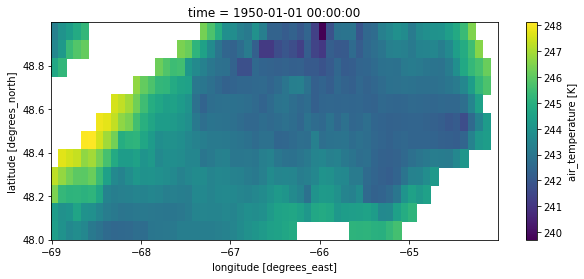

In [1]:
from siphon.catalog import TDSCatalog
from clisops.core import subset
import xarray as xr

import warnings
warnings.simplefilter('ignore')
# TODO change address
url = "http://pavics.ouranos.ca:8083/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"

# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec
# This does not download the entire dataset, just the metadata and attributes describing the content. 
lon_bnds = [-69, -64]
lat_bnds = [48, 49]
ds = subset.subset_bbox(xr.open_dataset(cat.datasets[0].access_urls["OPENDAP"], chunks=dict(time=256*2, lat=32, lon=32)), lon_bnds=lon_bnds, lat_bnds=lat_bnds)

# What we see here is an in-memory representation of the full content, the actual data is still on the server.
display(ds)

# plot of single day tasmin
ds.tasmin.isel(time=0).plot(figsize=(10,4))

<a id='climcalc'></a>
## Climate indicator calculation
The `atmos` module allows us to easily calculate a large number of climate indicators. For example we can determine the projected the number of days with maximum temperature above a threshold for our test dataset using the `atmos.tx_days_above`.  The vast majority of `xclim.atmos` calculations employ a resample frequency parameter `freq` trivializing the calculation of yearly (`'YS'`), monthly (`'MS'`), seasonal (`'QS-DEC'`) or other frequencies following pandas [resampling offsets](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) 

*[return to top of page](#top)*

calculating yearly output using freq="YS"


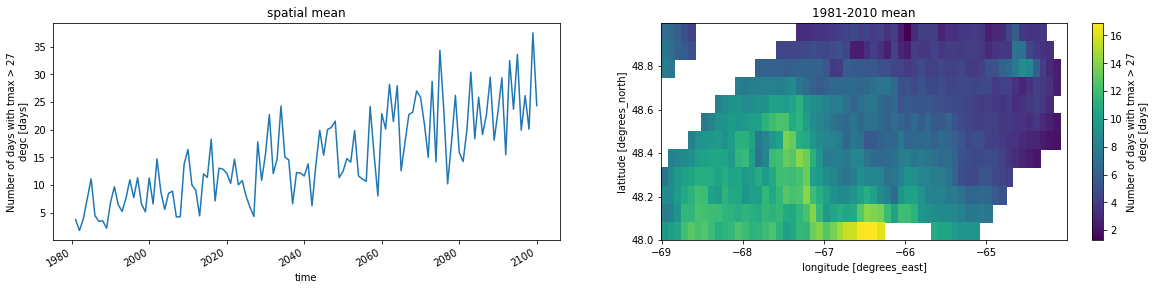

In [10]:
from xclim import atmos
import matplotlib.pyplot as plt

print(f'calculating yearly output using freq="YS"')
out = atmos.tx_days_above(tasmax=ds.tasmax, thresh='27 degC', freq='YS') # Yearly frequency

# Average over spatial domain and plot time-series
fig1 = plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
out.mean(dim=['lon','lat'], keep_attrs=True).plot()
plt.title('spatial mean')

# Calculate a 30 year climatology and plot a map
plt.subplot(1,2,2)
subset.subset_time(out, start_date='1981', end_date='2010').mean(dim='time', keep_attrs=True).plot()
plt.title('1981-2010 mean')
display()

___
<a id='missing'></a>
### Missing data options
Some data sets require consideration of how best to deal with possible missing data in the input time-series. For example, The World Meteorological Organisation recommends that where monthly means are computed from daily values, it should considered missing if either of these two criteria are met:  observations are missing for 11 or more days during the month; observations are missing for a period of 5 or more consecutive days during the month.  Stricter criteria are sometimes used in practice, with a tolerance of 5 missing values or 3 consecutive missing values, or in other cases one may simply wish to use a simple percent threshold demonstrated below

The `xclim.set_options` can be used to choose from a number of [missing data options](https://xclim.readthedocs.io/en/stable/checks.html#missing-values-identification).  


*[return to top of page](#top)*

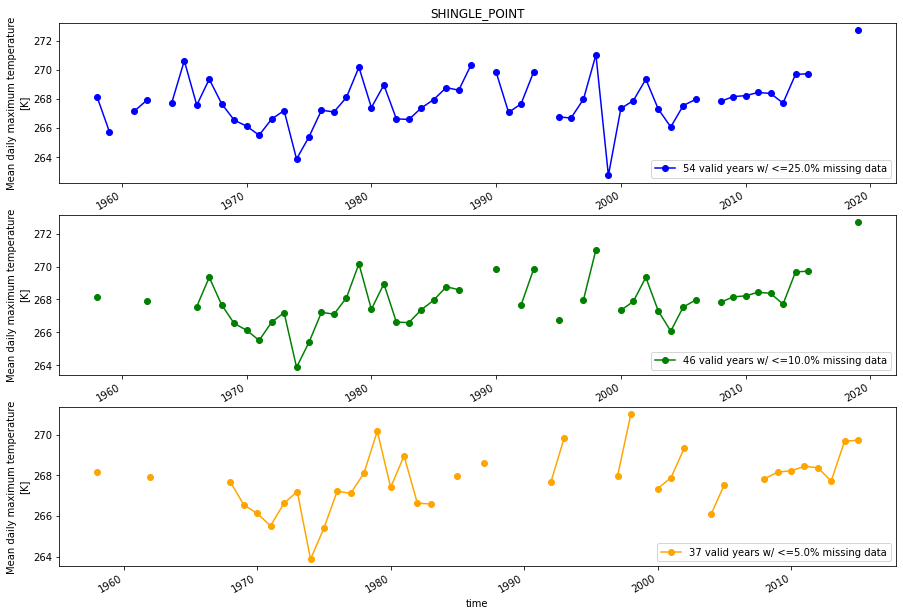

In [11]:
import xclim
# Access some station data
ds_stat = xr.open_dataset("http://pavics.ouranos.ca:8083/twitcher/ows/proxy/thredds/dodsC/birdhouse/eccc/adjusted_homogenized_station_data/ahccd_gen3_tasmax.nc", chunks=dict(station=1))
istat = 10
# Compare use of differernt percent tolerance levels  (tolerance == 0.1)
plt.figure(figsize=(15,10))
color = ['blue','green','orange']

for i, tol in enumerate([0.25, 0.1, 0.05]):
    plt.subplot(3,1, i+1)
    with xclim.set_options(check_missing='pct', missing_options={'pct': {'tolerance': tol}}):
        
        tx_mean = xclim.atmos.tx_mean(tasmax=ds_stat.isel(station=istat).tasmax, freq='YS') # compute monthly max tasmax
        
        tx_mean.plot(marker='o', color=color[i], label=f"{len(tx_mean.dropna('time').values)} valid years w/ <={tol*100}% missing data")
        plt.title('')
        plt.xlabel('')
        if i==0:
            plt.title(ds_stat.isel(station=istat).station_name.values)
        elif i==2:
            plt.xlabel('time')
    
        plt.legend(loc='lower right')

<a id='french'></a>
### Adding french language metadata fields

Climate indicator output can be customized to include addtional translated metadata fields. French translations are built in thus using the appropriate `xclim.set_options` for [internationalization](https://xclim.readthedocs.io/en/stable/internationalization.html#) during climate indicator calculations we note the additional `description_fr` and `longname_fr` attributes. 

*[return to top of page](#top)*

In [12]:
with xclim.set_options(metadata_locales=['fr']):
    out_fr = atmos.tx_days_above(tasmax=ds.tasmax,
                                thresh = '27 degC', 
                                freq='YS') 
out_fr

<xarray.DataArray 'tx_days_above' (time: 120, lat: 12, lon: 60)>
dask.array<where, shape=(120, 12, 60), dtype=float64, chunksize=(1, 12, 60), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2100-01-01
  * lat      (lat) float32 48.96 48.87 48.79 48.71 ... 48.29 48.21 48.12 48.04
  * lon      (lon) float32 -68.96 -68.88 -68.8 -68.71 ... -64.21 -64.13 -64.05
Attributes:
    units:           days
    cell_methods:     time: maximum within days time: sum over days
    xclim_history:   [2021-02-12 13:42:53] tx_days_above: tx_days_above(tasma...
    standard_name:   number_of_days_with_air_temperature_above_threshold
    long_name:       Number of days with tmax > 27 degc
    description:     Annual number of days where daily maximum temperature ex...
    long_name_fr:    Nombre de jours avec Tmax > 27 degC
    description_fr:  Nombre annuel de jours où la température journalière max...
    comment_fr:

___

### Advanced Topics
<a id='multiproc'></a>
#### Parallel processing of the entire ensemble

xclim uses `xarray` and its built-in support of `Dask` parallelization for most of its operations allowing for simple configuration of climate indicator calculation employing [parallel computing](http://xarray.pydata.org/en/stable/dask.html).  Here we show a simple workflow to calculate climate indicator(s) for all simulations (n=22) in the `cb-oura-1.0` ensemble.  The calculations are computed in parralel via a `dask.distributed` client of worker processes 

*[return to top of page](#top)*

In [5]:
from dask import compute
from dask.distributed import Client
from pathlib import Path


url = "http://pavics.ouranos.ca:8083/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"
# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec 
lon_bnds = [-69, -64]
lat_bnds = [48, 49]
start_date = '1981'

# sub function for atmos indicator call and write to netcdf
def indicator_calc(func, outfile, args):
    
    return func(**args).to_netcdf(outfile, mode='w', compute=False)
               
# Dictionary of atmos calculations to perform
calcs = []
calcs.append(dict(func=atmos.tx_days_above, args=dict(thresh='27 degC',freq='YS')))

with Client() as client:
    display(client)
    
    for c in calcs: 
        
        jobs = []
       
        prefix = '-'.join([f"{c['args'][c1]}" for c1 in c['args'] if type(c['args'][c1]) == str])
        prefix = f"{c['func'].identifier}_{prefix.replace(' ','_')}"

        print('preparing calculations ... ')
        for d in [cat.datasets[x] for x in cat.datasets]:
            outfile = Path('output').joinpath(d.name.replace('day_',f"{prefix}_" ).replace('1950',start_date).replace('.ncml','.nc'))
            outfile.parent.mkdir(parents=True, exist_ok=True)

            ds = subset.subset_bbox(xr.open_dataset(d.access_urls["OPENDAP"], chunks=dict(time=256*2)), lon_bnds=lon_bnds, lat_bnds=lat_bnds, start_date=start_date)

            # add dataset to inpu args
            args = c['args']
            args['ds']=ds

            jobs.append(indicator_calc(c['func'], outfile, args))

        print('computing with dask client ...')
        compute(jobs)
        client.restart()
        print('finished')


Client Scheduler: tcp://127.0.0.1:39059 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 20.27 GB


preparing calculations ... 
computing with dask client ...
finished
